#### Regression coefficient analysis

In [76]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from scipy.optimize import curve_fit, optimize
from scipy.stats import linregress

import pickle
import os
import glob
import pathlib
from pathlib import Path
import re 
import sys
from pynwb import NWBHDF5IO
import shutil
import time
from joblib import Memory

from IPython.display import display, HTML

sys.path.insert(1, '/root/capsule/code/utils')
import behavior_utils as bu
import array_utils as au

file_path = '/root/capsule/data/foraging_nwb_bonsai_processed/662914_2023-09-22/662914_2023-09-22_df_session_logistic_regression_df_beta_Su2022.pkl'

In [3]:
# NOTE: Exclude auto_water choices, set df_trial.auto_waterR | df_trial.auto_waterL == np.nan, need a way to balance out block length elongation 

# choice_history = df_trial['animal_response'].values
# choice_history[choice_history == 2] = np.nan
# reward_history = (df_trial.rewarded_historyL | df_trial.rewarded_historyR | 
#                     df_trial.auto_waterR | df_trial.auto_waterL 
#                     & (df_trial.animal_response != 2)
#                     ).astype(int).values

In [4]:
with open(file_path, 'rb') as file:
    data = pickle.load(file)
print(data.shape)

(1, 31)


In [5]:
# Load in session DataFrame
folder = '/root/capsule/data/filtered_data_session/filtered_data_20241107.csv'
session_df = pd.read_csv(folder)

/tmp/ipykernel_8038/2073535739.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  session_df = pd.read_csv(folder)


In [6]:
print(data.info())
print(data.index.names)
print(data.columns.names)

for name in data.index.names:
    print(f"Unique values in {name}:", data.index.get_level_values(name).unique())

for name in data.columns.names:
    print(f"Unique values in {name}:", data.columns.get_level_values(name).unique())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1 entries, ('662914', '2023-09-22', 0) to ('662914', '2023-09-22', 0)
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   (RewC, 15.0)  1 non-null      float64
 1   (RewC, 14.0)  1 non-null      float64
 2   (RewC, 13.0)  1 non-null      float64
 3   (RewC, 12.0)  1 non-null      float64
 4   (RewC, 11.0)  1 non-null      float64
 5   (RewC, 10.0)  1 non-null      float64
 6   (RewC, 9.0)   1 non-null      float64
 7   (RewC, 8.0)   1 non-null      float64
 8   (RewC, 7.0)   1 non-null      float64
 9   (RewC, 6.0)   1 non-null      float64
 10  (RewC, 5.0)   1 non-null      float64
 11  (RewC, 4.0)   1 non-null      float64
 12  (RewC, 3.0)   1 non-null      float64
 13  (RewC, 2.0)   1 non-null      float64
 14  (RewC, 1.0)   1 non-null      float64
 15  (UnrC, 15.0)  1 non-null      float64
 16  (UnrC, 14.0)  1 non-null      float64
 17  (UnrC, 13.0)  1 non-null 

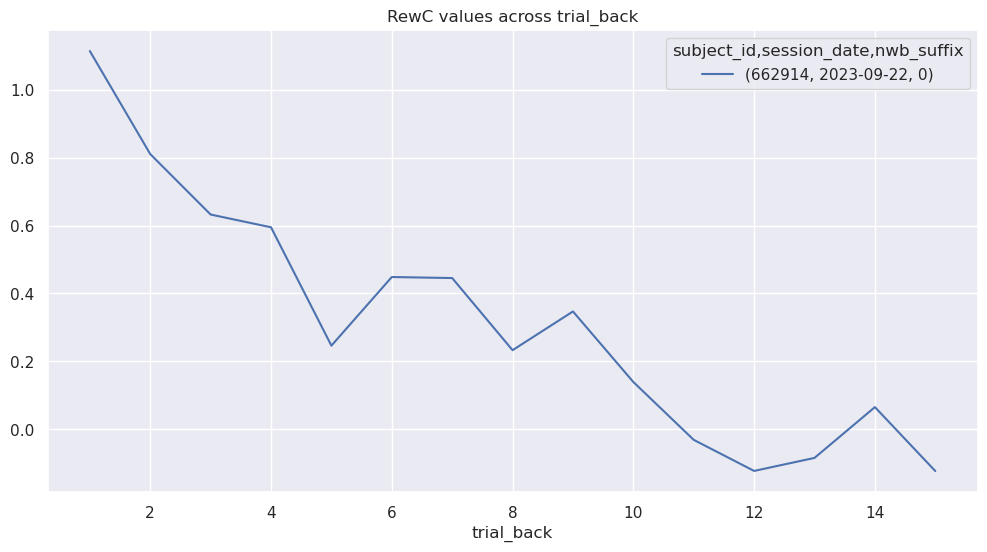

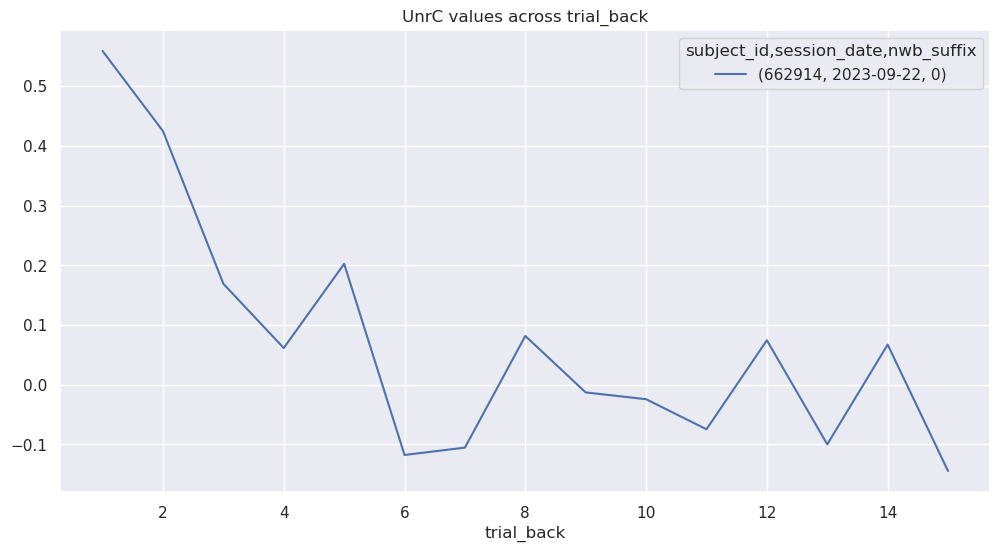

None


In [7]:

sns.set_theme()

# Plot Rewarded Choice
data['RewC'].T.plot(figsize=(12, 6))
plt.title('RewC values across trial_back')
plt.show()

# Plot Unrewarded Choice
data['UnrC'].T.plot(figsize=(12, 6))
plt.title('UnrC values across trial_back')
plt.show()

x = data['UnrC'].values.tolist()

print(x.reverse())

In [8]:
# folder = '/root/capsule/scratch'
# for filename in os.listdir(folder):
#     file_path = os.path.join(folder, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))

In [9]:
# cachedir = '/root/capsule/scratch'
# memory = Memory(cachedir, verbose=0)

# @memory.cache
# def process_single_dataset(pkl_file_path): 
#     """ 
#     Process single pkl dataset and extract values

#     Params:
#     pkl_file_path (str or Path): Path to the pkl file 
#     """ 
#     try:
#         # Load pkl and extract values
#         with open(pkl_file_path, 'rb') as file:
#             df = pickle.load(file) 

#         rewc_values = {}
#         unrc_values = {}

#         for trial_back in range(1,16):
#             rewc_values[trial_back] = df[('RewC', trial_back)].iloc[0]
#             unrc_values[trial_back] = df[('UnrC', trial_back)].iloc[0]

#         results_df = pd.DataFrame({
#             'trial_back': range(1,16),
#             'RewC': [rewc_values[i] for i in range(1,16)],
#             'UnrC': [unrc_values[i] for i in range(1,16)]
#         })

#         # Get subject_id and session_date
#         parts = pkl_file_path.stem.split('_')
#         subject_id = parts[0]
#         session_date = parts[1]

#         # Save extracted values to output directory
#         output_file = Path('/root/capsule/scratch') / f'{subject_id}_{session_date}.csv'
#         results_df.to_csv(output_file, index=False)
#         print(f'Successfully processed: {pkl_file_path.name}')

#     except (KeyError, IndexError) as e:
#         print(f'Error processing: {pkl_file_path.name}: {str(e)}')

In [10]:
# base_dir = Path('/root/capsule/data/foraging_nwb_bonsai_processed')
# pkl_files = [f for f in base_dir.glob('*/*_df_session_logistic_regression_df_beta_Su2022.pkl') if f.is_file()]

# for pkl_file in pkl_files:
#     process_single_dataset(pkl_file)

In [11]:
# Filename metadata extraction 

def extract_metadata_from_filename(file_path): 
    filename = file_path.split('/')[-1]
    match = re.match(r'(\d{6})_(\d{4}-\d{2}-\d{2})\.csv$', filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [12]:
# Create master DataFrame

csv_files = glob.glob('/root/capsule/data/temp_regression_trials/*.csv')

dataframes = []

for file in csv_files:
    filename = file.split('/')[-1]

    if not re.match(r'\d{6}_\d{4}-\d{2}-\d{2}\.csv$', filename):
        continue

    try: 
        df = pd.read_csv(file)
        df.columns = df.columns.str.strip()
        df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove special characters

        # Extract subject_id, session_date from metadata 
        subject_id, session_date = extract_metadata_from_filename(file)

        if subject_id is None or session_date is None:
            print(f'Could not extract metada from {filename}')
            continue
    
        df['subject_id'] = subject_id
        df['session_date'] = session_date

        dataframes.append(df)
    except Exception as e:
        print(f'Error processing {file}: {e}')

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['subject_id'] = pd.to_numeric(combined_df['subject_id'], errors='coerce')


In [13]:
combined_df

,trial_back,RewC,UnrC,subject_id,session_date
0,1,0.000699,-2.116513e-07,722683,2024-05-30
1,2,0.000499,-2.000241e-04,722683,2024-05-30
2,3,0.000149,-5.002596e-05,722683,2024-05-30
3,4,0.000049,-5.025006e-05,722683,2024-05-30
4,5,0.000499,9.971576e-05,722683,2024-05-30
...,...,...,...,...,...
80830,11,-1.261685,0.000000e+00,743986,2024-10-28
80831,12,-3.802893,0.000000e+00,743986,2024-10-28
80832,13,-0.561230,0.000000e+00,743986,2024-10-28
80833,14,-1.139188,0.000000e+00,743986,2024-10-28


<Axes: xlabel='trial_back', ylabel='RewC'>

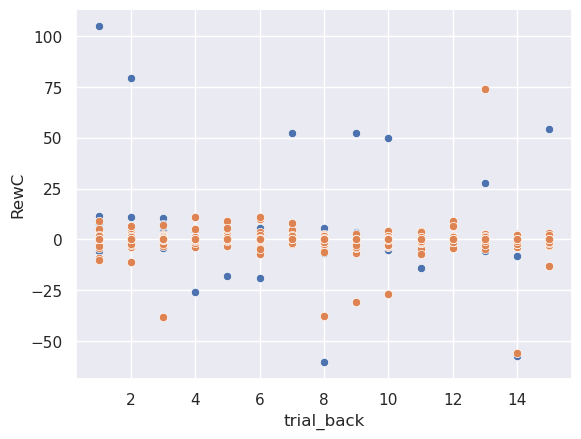

In [14]:
sns.scatterplot(combined_df, x='trial_back', y='RewC')
sns.scatterplot(combined_df, x='trial_back', y='UnrC')

In [17]:
def remove_outliers(df, rew_iqr_factor=5, unr_iqr_factor=5):
    """
    Removes outliers from the dataframe based on the IQR of regression coefficient columns
    
    Params: 
    df (pandas.DataFrame): The input dataframe
    rew_iqr_factor (float): Factor for determining RewC outliers
    unr_iqr_factor (float): Factor for determining UnrC outliers 
    
    Returns:
    pandas.DataFrame: The filtered dataframe with outliers removed
    """
    # Calculate the IQR for RewC and UnrC
    rew_q1 = df['RewC'].quantile(0.25)
    rew_q3 = df['RewC'].quantile(0.75)
    rew_iqr = rew_q3 - rew_q1
    
    unr_q1 = df['UnrC'].quantile(0.25)
    unr_q3 = df['UnrC'].quantile(0.75)
    unr_iqr = unr_q3 - unr_q1
    
    # Calculate the upper and lower bounds for outliers
    rew_lower = rew_q1 - rew_iqr_factor * rew_iqr
    rew_upper = rew_q3 + rew_iqr_factor * rew_iqr
    
    unr_lower = unr_q1 - unr_iqr_factor * unr_iqr
    unr_upper = unr_q3 + unr_iqr_factor * unr_iqr
    
    # Filter the dataframe based on the outlier bounds
    filtered_df = df[
        (df['RewC'] >= rew_lower) & (df['RewC'] <= rew_upper) &
        (df['UnrC'] >= unr_lower) & (df['UnrC'] <= unr_upper)
    ]
    
    
    return filtered_df

In [18]:
filtered_df = remove_outliers(combined_df)

filtered_df

,trial_back,RewC,UnrC,subject_id,session_date
0,1,0.000699,-2.116513e-07,722683,2024-05-30
1,2,0.000499,-2.000241e-04,722683,2024-05-30
2,3,0.000149,-5.002596e-05,722683,2024-05-30
3,4,0.000049,-5.025006e-05,722683,2024-05-30
4,5,0.000499,9.971576e-05,722683,2024-05-30
...,...,...,...,...,...
80829,10,1.317453,0.000000e+00,743986,2024-10-28
80830,11,-1.261685,0.000000e+00,743986,2024-10-28
80832,13,-0.561230,0.000000e+00,743986,2024-10-28
80833,14,-1.139188,0.000000e+00,743986,2024-10-28


<Axes: xlabel='trial_back', ylabel='RewC'>

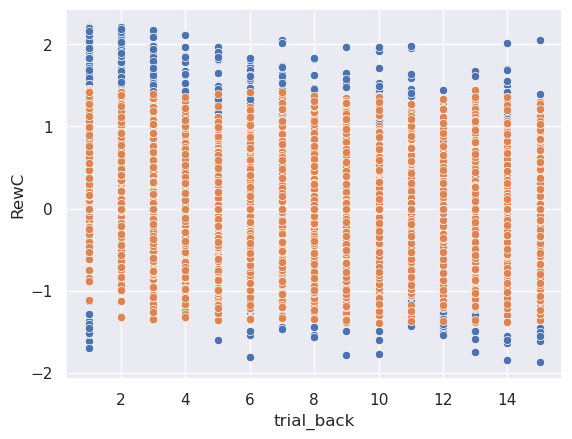

In [19]:
sns.scatterplot(filtered_df, x='trial_back', y='RewC')
sns.scatterplot(filtered_df, x='trial_back', y='UnrC')

In [20]:
def remove_incompletes(df):
    """
    Remove subject_id/session_date pairs with less than full number of trial_backs

    Params:
    df (DataFrame): Input DataFrame

    Returns:
    DataFrame: DataFrame with only complete sessions
    """ 

    # Group by subject_id and session_date, count unique trial_back values
    session_counts = df.groupby(['subject_id', 'session_date'])['trial_back'].nunique()

    # Filter for only complete sessions (15)
    complete_sessions = session_counts[session_counts == 15].index.to_frame(index=False)

    # Merge back to only get completed session rows
    filtered_df = df.merge(
        complete_sessions, 
        on=['subject_id', 'session_date'],
        how='inner'
        )

    return filtered_df

In [21]:
filtered_comp_df = remove_incompletes(filtered_df)

filtered_comp_df

,trial_back,RewC,UnrC,subject_id,session_date
0,1,0.000699,-2.116513e-07,722683,2024-05-30
1,2,0.000499,-2.000241e-04,722683,2024-05-30
2,3,0.000149,-5.002596e-05,722683,2024-05-30
3,4,0.000049,-5.025006e-05,722683,2024-05-30
4,5,0.000499,9.971576e-05,722683,2024-05-30
...,...,...,...,...,...
66310,11,0.030827,0.000000e+00,750107,2024-09-03
66311,12,-0.025633,0.000000e+00,750107,2024-09-03
66312,13,-0.055741,0.000000e+00,750107,2024-09-03
66313,14,-0.081766,0.000000e+00,750107,2024-09-03


<Axes: xlabel='trial_back', ylabel='RewC'>

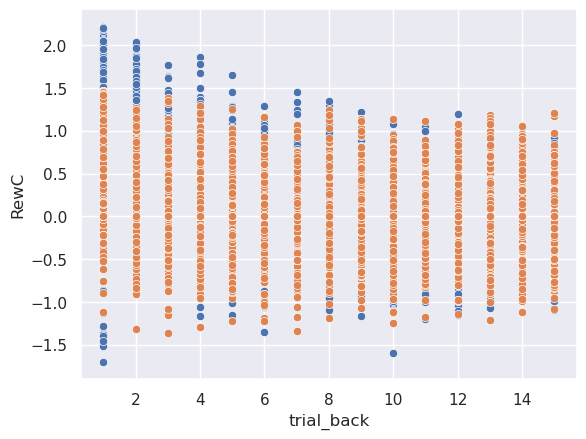

In [22]:
sns.scatterplot(filtered_comp_df, x='trial_back', y='RewC')
sns.scatterplot(filtered_comp_df, x='trial_back', y='UnrC')

In [58]:
# Negative coefficient value anomaly 

def analyze_coefficients(df):
    """
    Analyze negative and positive coefficient values across different dimensions
    
    Params:
    df (DataFrame): Input DataFrame
    
    Returns:
    dict: Analysis of coefficient distributions
    """
    # seperate negative and positive coefficients
    neg_rew = df[df['RewC'] < 0]
    pos_rew = df[df['RewC'] > 0]
    neg_unr = df[df['UnrC'] < 0]
    pos_unr = df[df['UnrC'] > 0]

    analysis = {
        'Rewarded Coefficients': {
            'Negative':{
                'total_count': len(neg_rew),
                'subjects': neg_rew['subject_id'].nunique(),
                'session_dates': neg_rew['session_date'].nunique(),
                'trial_back_distribution': neg_rew['trial_back'].value_counts(),
            },
            'Positive': {
                'total_count': len(pos_rew),
                'subjects': pos_rew['subject_id'].nunique(),
                'session_dates': pos_rew['session_date'].nunique(),
                'trial_back_distribution': pos_rew['trial_back'].value_counts()
        }
    },

        'Unrewarded Coefficients': {
            'Negative':{
                'total_count': len(neg_unr),
                'subjects': neg_unr['subject_id'].nunique(),
                'session_dates': neg_unr['session_date'].nunique(),
                'trial_back_distribution': neg_unr['trial_back'].value_counts(),
            },
            'Positive': {
                'total_count': len(pos_unr),
                'subjects': pos_unr['subject_id'].nunique(),
                'session_dates': pos_unr['session_date'].nunique(),
                'trial_back_distribution': pos_unr['trial_back'].value_counts()
            }
        }
    }
    
    return analysis


def print_analysis_summary(analysis):
    for coef_type, coef_data in analysis.items():
        print(f' {coef_type}:')
        for sign, data in coef_data.items():
            print(f"  {sign} Coefficients:")
            print(f"    Total Count: {data['total_count']}")
            print(f"    Unique Subjects: {data['subjects']}")
            print(f"    Unique Session Dates: {data['session_dates']}")
            print("    Trial Back Distribution:")
            print(data['trial_back_distribution'])


In [59]:
analysis_results = analyze_coefficients(filtered_comp_df)
print_analysis_summary(analysis_results)

 Rewarded Coefficients:
  Negative Coefficients:
    Total Count: 17577
    Unique Subjects: 258
    Unique Session Dates: 341
    Trial Back Distribution:
trial_back
15    2271
14    2209
13    2057
12    2019
11    1778
10    1625
9     1437
8     1244
7     1041
6      779
5      552
4      332
3      154
1       45
2       34
Name: count, dtype: int64
  Positive Coefficients:
    Total Count: 48738
    Unique Subjects: 259
    Unique Session Dates: 345
    Trial Back Distribution:
trial_back
2     4387
1     4376
3     4267
4     4089
5     3869
6     3642
7     3380
8     3177
9     2984
10    2796
11    2643
12    2402
13    2364
14    2212
15    2150
Name: count, dtype: int64
 Unrewarded Coefficients:
  Negative Coefficients:
    Total Count: 28352
    Unique Subjects: 259
    Unique Session Dates: 342
    Trial Back Distribution:
trial_back
8     2298
10    2269
6     2237
7     2233
9     2216
12    2212
11    2211
14    2207
15    2187
13    2165
5     2070
4     1869
3     1

In [72]:
def calculate_negative_percentage(df):
    combinations = df[['subject_id', 'session_date']].drop_duplicates()

    # Initialize lists 
    results = []

    for _, combo in combinations.iterrows():
        subject = combo['subject_id']
        session = combo['session_date']

        # Get data for this combination
        combo_data = df[(df['subject_id'] == subject) &
                        (df['session_date'] == session)]

        total_rows = len(combo_data)

        neg_rewc_count = len(combo_data[combo_data['RewC'] < 0])
        neg_unrc_count = len(combo_data[combo_data['UnrC'] < 0])

        neg_rewc_percent = np.round((neg_rewc_count / total_rows * 100), 2)
        neg_unrc_percent = np.round((neg_unrc_count / total_rows * 100), 2)
        
        results.append({
            'subject_id': subject,
            'session_date': session,
            'total_trials': total_rows,
            'neg_rewc_percent': neg_rewc_percent,
            'neg_unrc_percent': neg_unrc_percent,
            'neg_rewc_count': neg_rewc_count,
            'neg_unrc_count': neg_unrc_count
        })

    results_df = pd.DataFrame(results)

    results_df = results_df.sort_values(['neg_rewc_percent', 'neg_unrc_percent'], ascending=[False, False])

    return results_df

In [74]:
negative_percent_df = calculate_negative_percentage(filtered_comp_df)

negative_percent_df.groupby('subject_id')

In [75]:
negative_percent_df

,subject_id,session_date,total_trials,neg_rewc_percent,neg_unrc_percent,neg_rewc_count,neg_unrc_count
4416,734137,2024-09-04,15,86.67,0.00,13,0
3303,690484,2024-02-05,15,80.00,33.33,12,5
917,699982,2023-11-09,15,73.33,46.67,11,7
368,710107,2024-04-26,15,73.33,40.00,11,6
3030,713557,2024-02-05,15,73.33,20.00,11,3
...,...,...,...,...,...,...,...
4335,722683,2024-07-09,15,0.00,0.00,0,0
4337,716866,2024-05-21,15,0.00,0.00,0,0
4381,743794,2024-10-02,15,0.00,0.00,0,0
4385,750108,2024-09-20,15,0.00,0.00,0,0


In [23]:
def average_across_sessions(df, n_sessions):
    """
    Average RewC and UnrC across every n sessions for each subject,
    using the maximum number of divisible sessions
    
    Params: 
    df (DataFrame): Input dataframe with columns: trial_back, RewC, UnrC, subject_id, session_date
    
    Returns:
    processed_subjects (DataFrame): Averaged dataframe with RewC and UnrC values aggregated across sets of 3 sessions
    """
    # Group sessions by subject_id and sort by session_date
    df_sorted = df.sort_values(['subject_id', 'session_date'])

    processed_subjects = []
    
    # Process each subject
    for subject, subject_data in df_sorted.groupby('subject_id'):
        # Find number of sessions for each subject 
        total_sessions = subject_data['session_date'].nunique()
        
        # Skip subjects with fewer than n sessions
        if total_sessions < n_sessions:
            continue
        
        # Find number of n-session sets
        num_sets = total_sessions // n_sessions
        
        subject_processed = []
        
        # Iterate through sets of n sessions
        for set_num in range(num_sets):
            # Select the subset of data for this n-session set
            start_index = set_num * n_sessions
            end_index = start_index + n_sessions
            
            # Get the sessions for this subset
            subset_sessions = subject_data['session_date'].unique()[start_index:end_index]
            
            # Filter data for these specific sessions
            subset_data = subject_data[subject_data['session_date'].isin(subset_sessions)].copy()
            
            # Average RewC and UnrC for each trial_back
            averaged_subset = subset_data.groupby('trial_back').agg({
                'RewC': 'mean',
                'UnrC': 'mean'
            }).reset_index()
            
            # Add subject and set information
            averaged_subset['subject_id'] = subject
            averaged_subset['session_group'] = set_num
            
            subject_processed.append(averaged_subset)
        
        # Combine sets for this subject
        if subject_processed:
            processed_subjects.append(pd.concat(subject_processed))
    
    # Combine data for all subjects
    if processed_subjects:
        return pd.concat(processed_subjects)[['subject_id', 'session_group', 'trial_back', 'RewC', 'UnrC']]
    else:
        return pd.DataFrame(columns=['subject_id', 'session_group', 'trial_back', 'RewC', 'UnrC'])


In [24]:
# Create wrapper function to remove incomplete sessions from outlier removal process

def compare_session_group_var(df, n_sessions_list):
    variance_results = []

    for n_sessions in n_sessions_list:
        # Get averaged data for current n_session
        processed_data = average_across_sessions(df, n_sessions)

        # Calculate variance for RewC and UnrC across trial_back for each subject
        subject_variances = processed_data.groupby('subject_id').agg({
            'RewC': 'var',
            'UnrC': 'var'
        }).reset_index()

        # Add info for each n_session
        subject_variances['n_sessions'] = n_sessions

        variance_results.append(subject_variances)

    # Combine results for all n_session values
    return pd.concat(variance_results)

In [25]:
n_sessions_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

variance_comparison = compare_session_group_var(filtered_comp_df, n_sessions_list)

In [26]:
variance_comparison

,subject_id,RewC,UnrC,n_sessions
0,662914,0.331804,0.130263,1
1,663612,0.363406,0.163455,1
2,668463,0.188180,0.087152,1
3,668546,0.205025,0.113164,1
4,668548,0.250451,0.063982,1
...,...,...,...,...
190,757128,0.146661,0.058954,9
191,757129,0.157083,0.057313,9
192,764769,0.169315,0.039027,9
193,764787,0.065468,0.023606,9


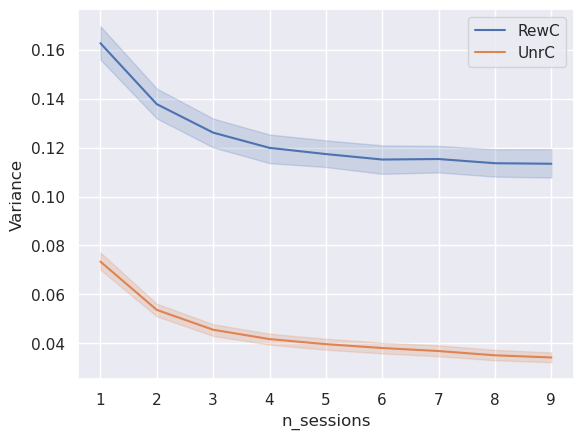

In [27]:
fig, ax = plt.subplots()


sns.lineplot(variance_comparison, x='n_sessions', y='RewC', ax=ax, label='RewC')
sns.lineplot(variance_comparison, x='n_sessions', y='UnrC', ax=ax, label='UnrC')

ax.set_ylabel('Variance')
ax.legend()
plt.show()

# Optimal n_sessions for variance bias tradeoff = 3

In [28]:
# Create averaged sessions 

n_sessions = 3

final_df = average_across_sessions(filtered_comp_df, n_sessions=n_sessions)

In [29]:
final_df

,subject_id,session_group,trial_back,RewC,UnrC
0,662914,0,1,1.523566,0.890437
1,662914,0,2,0.818209,0.441141
2,662914,0,3,0.574436,0.283190
3,662914,0,4,0.553988,0.126843
4,662914,0,5,0.074809,0.304610
...,...,...,...,...,...
10,769888,0,11,0.007788,0.058932
11,769888,0,12,-0.143984,0.033241
12,769888,0,13,0.067141,-0.137759
13,769888,0,14,0.048814,0.005362


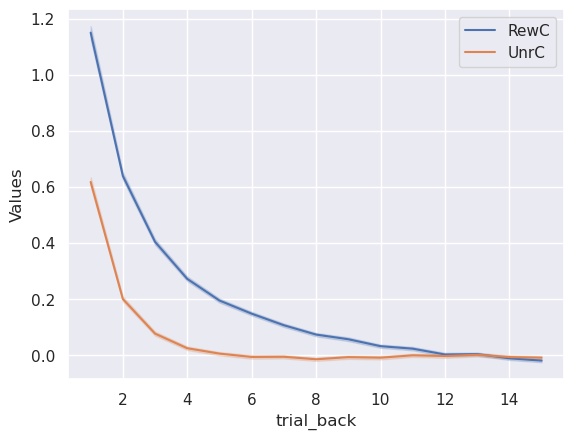

trial back values: [ 1  2  3 ... 13 14 15], 
 RewC values: [ 1.52356609  0.818209    0.57443579 ...  0.06714084  0.04881401
 -0.06559528], 
 UnrC values: [ 0.89043672  0.44114145  0.28319032 ... -0.13775914  0.00536209
 -0.0937279 ]


In [30]:
mean_final_df = final_df.groupby('trial_back', as_index=False)[['RewC', 'UnrC']].mean()

fig, ax = plt.subplots()

sns.lineplot(final_df, x='trial_back', y='RewC', ax=ax, label='RewC')
sns.lineplot(final_df, x='trial_back', y='UnrC', ax=ax, label='UnrC')

ax.set_ylabel('Values')
ax.legend()
plt.show()

x = final_df['trial_back'].values
y = final_df['RewC'].values
y_unrc = final_df['UnrC'].values

print(f'trial back values: {x}, \n RewC values: {y}, \n UnrC values: {y_unrc}')

In [78]:
def exponent_decay(x, a, b, c):
    """ 
    Params:
    x: input
    a: amplitude
    z: amplitude (no elbow movement)
    b: decay rate
    c: asymptote
    """ 

    return a * np.exp(z * (-b * x)) + c

In [77]:
def log_decay(x, a, b, asymptote):
    """ 
    Params:
    x: input
    a: scaling factor
    b: shape parameter
    asymptote: horizontal asymptote value
    """ 

    return a * np.log(x + 1) + b + asymptote